## Inference 

In this notebook we will test out the pretrained model. Check out how its performing, where it is looking at the image and we will try to confuse it to see its limits. Some of the initial stuff is pretty much same with the training notebook so we will skip explanation.

In [1]:
!pip install -q transformers
!pip install -q datasets
!pip install -q peft

In [2]:
import json

with open('kaggle.json') as f:
  kaggle_dictionary = json.load(f)

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = kaggle_dictionary["username"]
os.environ['KAGGLE_KEY'] = kaggle_dictionary["key"]

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k # download flicker8k dataset

In [ ]:
!unzip -q flickr8k.zip

In [ ]:
!kaggle datasets download -d begum302553/tasviret-flickr8k-turkish #download TasvirEt caption dataset

In [7]:
!unzip -q tasviret-flickr8k-turkish.zip

In [8]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast ,CLIPImageProcessor
from tqdm import tqdm

In [9]:
data = pd.read_json("tasviret8k_captions.json")

In [10]:
data.head()

images   dataset
0  {'split': 'train', 'filename': '2513260012_03d...  flickr8k
1  {'split': 'train', 'filename': '2903617548_d3e...  flickr8k
2  {'split': 'train', 'filename': '3338291921_fe7...  flickr8k
3  {'split': 'train', 'filename': '488416045_1c6d...  flickr8k
4  {'split': 'train', 'filename': '2644326817_8f4...  flickr8k

Lets load both our finetuned and original CLIP models for comparison.

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.load_adapter("kesimeg/lora-turkish-clip")
model.eval()

In [ ]:
original_clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
original_clip_model.eval()

In the following cell we implement image load method and prediction methods for both models.

In [13]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def load_image(id,saliency=False):
  val_set = data[7000:]
  file_name = val_set["images"].values[id]["filename"]
  if saliency == False:
    captions = val_set["images"].values[id]["sentences"]
    for (i,caption) in zip(range(len(captions)),captions):
      print("Caption {}: ".format(i),caption["raw"])

  img = Image.open("./Images/{}".format(file_name))
  if saliency == False:
    plt.imshow(img)
    plt.show()
  return img

def predict(image,text_list):
  inputs = processor(text=text_list, images=image, return_tensors="pt", padding=True)

  outputs = model(**inputs)
  logits_per_image = outputs.logits_per_image
  probs = logits_per_image.softmax(dim=1)
  print(probs)

def original_clip_predict(image,text_list):
  inputs = processor(text=text_list, images=image, return_tensors="pt", padding=True)

  outputs = original_clip_model(**inputs)
  logits_per_image = outputs.logits_per_image
  probs = logits_per_image.softmax(dim=1)
  print(probs)

To see where the model is looking at we will use saliency gradient method. This method basically shows the regions which triggers the model to give its final output values. We add random noise to our image and repeat this process many times and take the average of the gradients in order to get smoother output.

In [14]:
def random_noise(image,param_sigma_multiplier):
  noise = torch.rand_like(image)


  mean = 0
  sigma = param_sigma_multiplier / (torch.max(image) - torch.min(image)).item()

  noise = noise.normal_(mean,sigma**2)

  return image+noise

In [15]:
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")
img_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [16]:
def compute_saliency_map(image_id,text_list,class_num,num_loop = 50):
  grad_img = torch.zeros(1,224,224)

  param_sigma_multiplier = 4

  img = load_image(image_id,True)
  criterion = nn.CrossEntropyLoss()

  input_dictionary = tokenizer.batch_encode_plus(batch_text_or_text_pairs=text_list, return_attention_mask=True, return_tensors='pt' ,padding=True)


  for i in tqdm(range(0,num_loop)):

      input_img = img_processor(images=img, return_tensors='pt')["pixel_values"]

      image_copy = input_img.clone()
      image_copy=random_noise(image_copy,param_sigma_multiplier)
      image_copy.requires_grad=True

      outputs = model(input_dictionary["input_ids"], image_copy , input_dictionary["attention_mask"])

      logits_per_image = outputs.logits_per_image

      label=torch.tensor([class_num])

      maxim,index=torch.max(logits_per_image,1)
      output_max = logits_per_image[:,index]
      output_max.backward()

      grad = image_copy.grad
      grad = torch.abs(grad)
      grad,_= torch.max(grad,dim=1)
      grad_img+=grad
  grad_img=grad_img/num_loop

  grad_img_norm = (grad_img - grad_img.min()) / (grad_img.max() - grad_img.min())
  resized_img = img.resize((224,224))
  grad_multiplied_img = torch.Tensor(np.array(resized_img)) * grad_img_norm.permute(1,2,0) / 255

  f, axarr = plt.subplots(1,3, figsize=(16, 16))
  axarr[0].imshow(resized_img)
  axarr[1].imshow(grad_img.squeeze(0),cmap = "inferno")
  axarr[2].imshow(grad_multiplied_img)

  return grad_img

Now lets load some images compare predictions of original and our finetuned CLIP and look at the places in the image that trigger the correct label 

Caption 0:  Üç köpek kameraya doğru koşuyorlar.
Caption 1:  Bir köşesinde sulak bir kısmın bulunduğu bir çayırda koşan üç köpek.


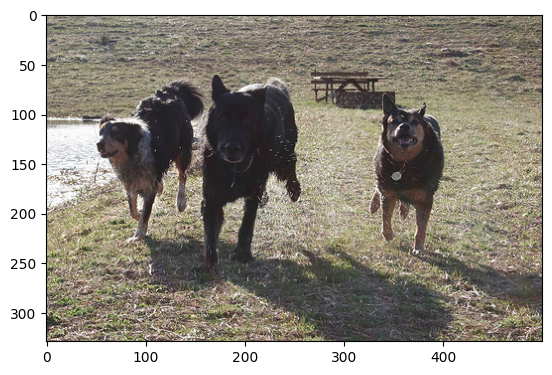

In [17]:
img = load_image(100)

In [18]:
text_list = ["Koşan iki köpek.","Koşan üç köpek.","Koşan dört köpek."] # Two running dogs, Three running dogs, Four running dogs
predict(img,text_list)
original_clip_predict(img,text_list)

tensor([[0.0262, 0.6449, 0.3288]])
tensor([[0.2378, 0.4869, 0.2753]], grad_fn=<SoftmaxBackward0>)


The probabilities above show the predictions of our LORA-CLIP and original CLIP. You can see that both models make the same decision (and both are correct) however LORA model gives higher probability to correct answer. In the images below you see the original image, heatmap of gradients or saliency map and finally important regions highlighted in the last image. You can see that the model focuses on the dogs. Also since our model is a transformer the image is divided into patches in the input layer. You can clearly see these patched in the saliency map. This makes the saliency map discrete. For comparison with convolution based models please checkout the inference notebook in the following repo (the image example are same) : [turkish-clip]

[turkish-clip]:https://github.com/kesimeg/turkish-clip/blob/main/Inference.ipynb

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


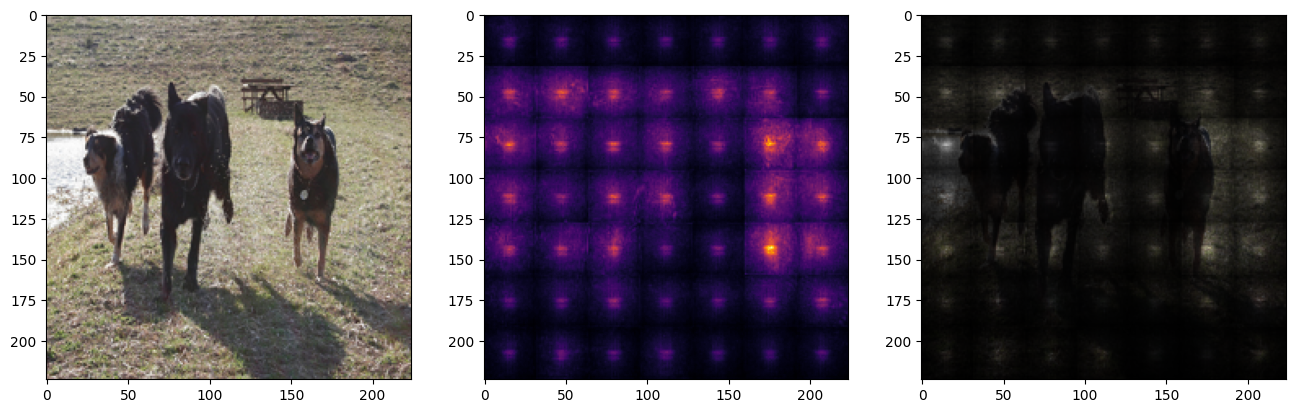

In [19]:
saliency = compute_saliency_map(100,text_list,class_num=1)

Caption 0:  Gün batımında sahilde oyun oynayan iki erkek çocuğu.
Caption 1:  İki çocuk güneş ufuktayken bir sahilde birlikte oyun oynuyorlar.


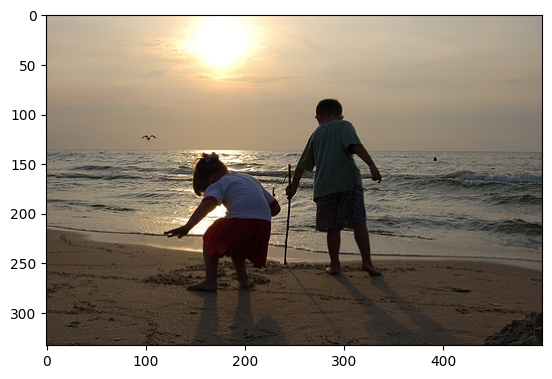

In [20]:
img = load_image(400)

In [21]:
text_list = ["Gün batımında kumla oynayan iki çocuk.","Gece kumla oynayan iki çocuk.","Kumla oynayan üç çocuk."]
# Two kids playing with sand during sun set, Two kids playing with sand at night, Three kids playing with sand
predict(img,text_list)
original_clip_predict(img,text_list)

tensor([[0.6600, 0.1978, 0.1422]])
tensor([[0.3701, 0.2802, 0.3496]], grad_fn=<SoftmaxBackward0>)


Again both models are correct and once again LORA model is more confident.

100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


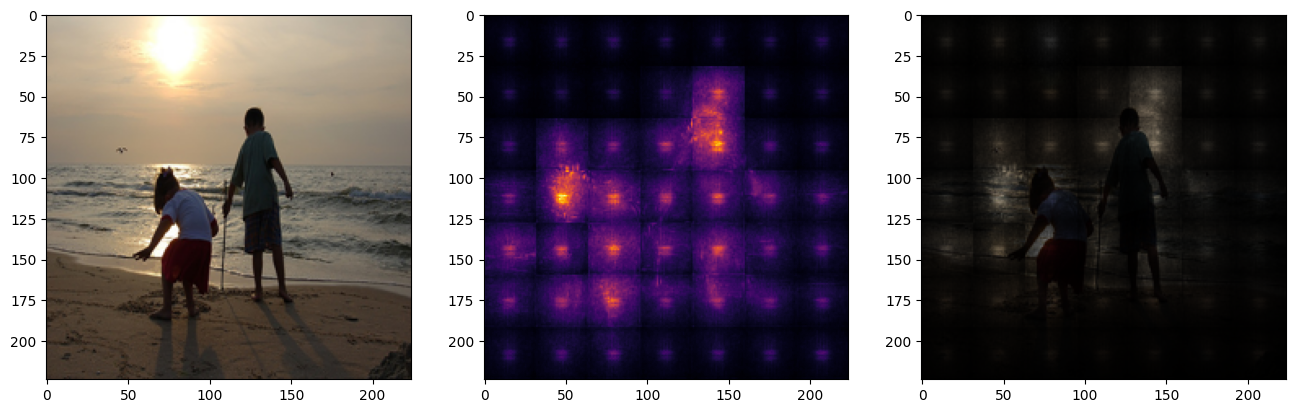

In [22]:
saliency = compute_saliency_map(400,text_list,class_num=0)

Caption 0:  İki kız çocuğu futbol oynuyor.
Caption 1:  Çimlerde antreman yapan genç kızlar.


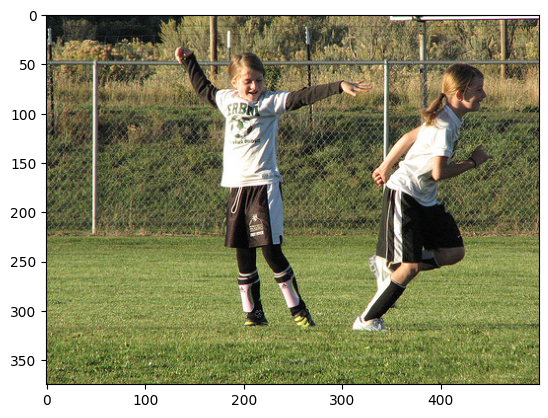

In [23]:
img = load_image(500)

In [24]:
text_list = ["İki oğlan çocuğu futbol oynuyor.","İki kız çocuğu futbol oynuyor."]
#Two boys are playing football, Two girls are playing football
predict(img,text_list)
original_clip_predict(img,text_list)

tensor([[0.4844, 0.5156]])
tensor([[0.5246, 0.4754]], grad_fn=<SoftmaxBackward0>)


In this example LORA model is wrong and original CLIP is correct but since the probabilty of the both captions are too close this might be a random guess where the model gave similar probabilities so that being right or wrong does not differ much (in terms of the loss)

100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


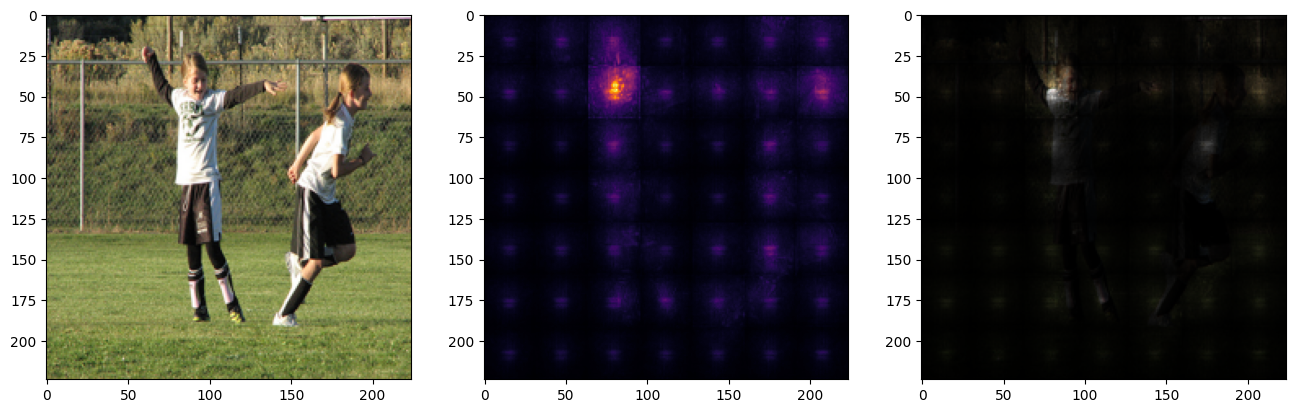

In [25]:
saliency = compute_saliency_map(500,text_list,class_num=1)

Caption 0:  Mavi tişörtlü bir çocuk kaykay yapıyor.
Caption 1:  Kaykaylı bir adam sokakta kayarken.


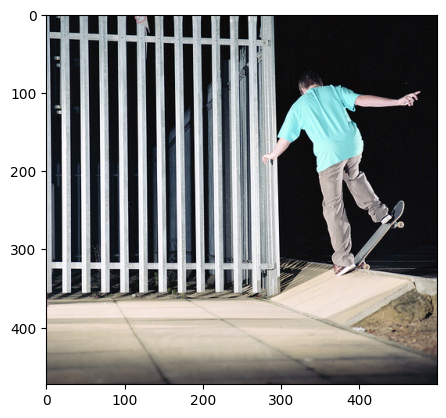

In [26]:
img = load_image(600)

In [27]:
text_list = ["Mavi tişörtlü bir kaykaycı.","Sarı tişörtlü bir kaykaycı.","Kırmızı tişörtlü bir kaykaycı."]
# A skateboarder with a blue t-shirt, A skateboarder with a yellow t-shirt, A skateboarder with a red t-shirt
predict(img,text_list)
original_clip_predict(img,text_list)

tensor([[0.3388, 0.3775, 0.2837]])
tensor([[0.3501, 0.3427, 0.3072]], grad_fn=<SoftmaxBackward0>)


Again original CLIP is right but the probabilities are too close once again.

In [28]:
text_list = ["Mavi tişörtlü bir çocuk kaykay yapıyor.","Sarı tişörtlü bir çocuk kaykay yapıyor.","Kırmızı tişörtlü bir çocuk kaykay yapıyor."]
predict(img,text_list)
original_clip_predict(img,text_list)

tensor([[0.2948, 0.4460, 0.2593]])
tensor([[0.3766, 0.3337, 0.2897]], grad_fn=<SoftmaxBackward0>)


To check if the wording effects the output the original caption is used with different colours however it does not seem to change the result in a good way. But it seems that the way the captions are written can actually change the probabilities.

100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


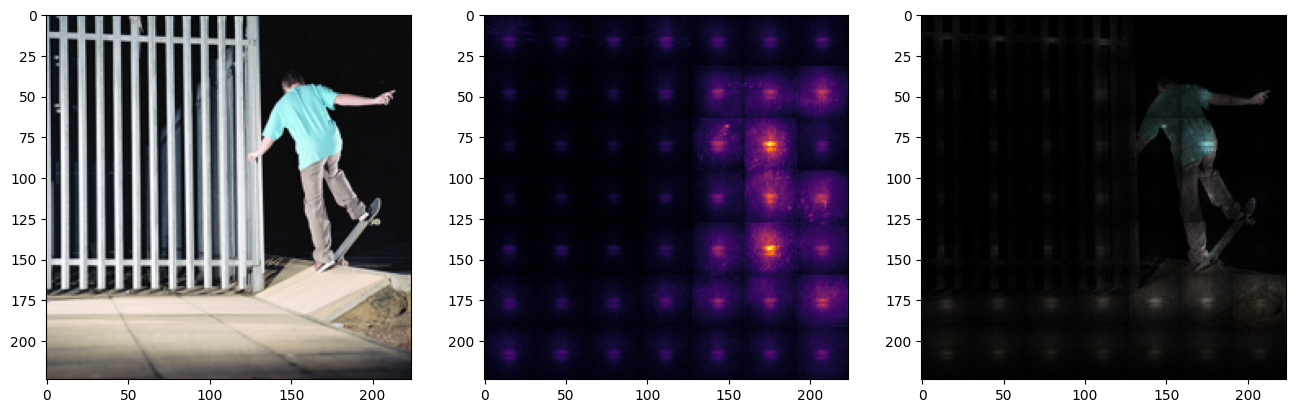

In [29]:
saliency = compute_saliency_map(600,text_list,class_num=0)

Caption 0:  Şelaleden akan su içinde dolaşan kız.
Caption 1:  Bir kız şelanin önünde sularda yürüyor.


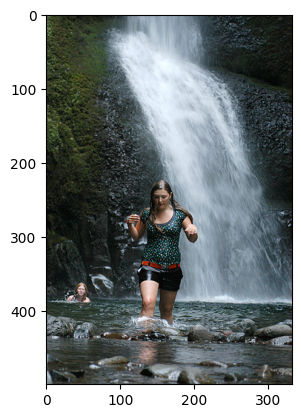

In [30]:
img = load_image(950)

In [31]:
text_list = ["Şelaleden su akıyor.","Şelaleden ateş akıyor.","Donmuş bir şelale."]
# Water flows from the waterfall, Flame flows from the waterfall, A frozen waterfall
predict(img,text_list)
original_clip_predict(img,text_list)

tensor([[0.5576, 0.4109, 0.0315]])
tensor([[0.0863, 0.2579, 0.6558]], grad_fn=<SoftmaxBackward0>)


The original captioning is "Girl wandering in the water flowing from the waterfall." Altough the girl is not mentioned in the sample above it seems that the model is not confused. Original CLIP thinks that this is a frozen waterfall, LORA CLIP get the caption right but somehow it thinks that flame flowing from a waterfall is probable.

100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


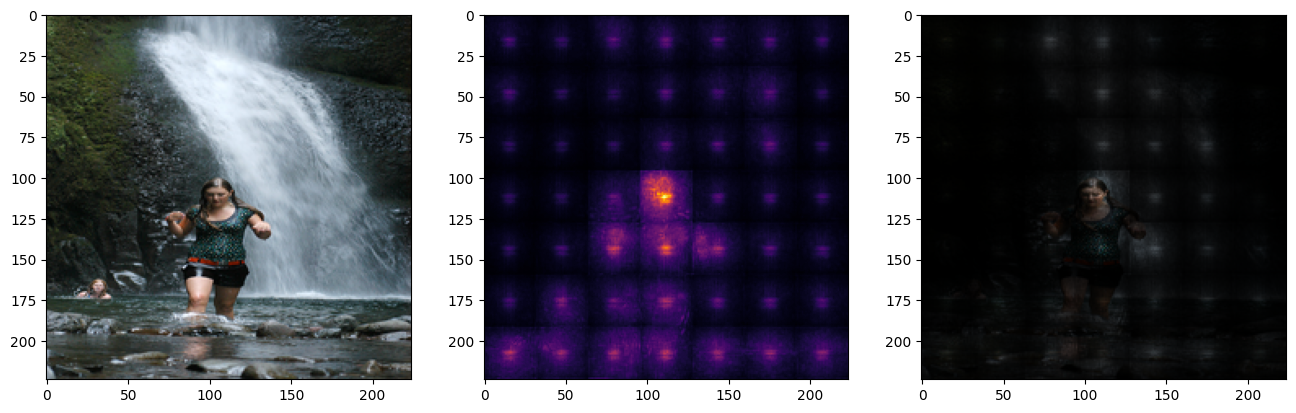

In [32]:
saliency = compute_saliency_map(950,text_list,class_num=0)

Caption 0:  Faleze tırmanan dağcı.
Caption 1:  İp ile kayalıklardan aşağıya inen sporcu.


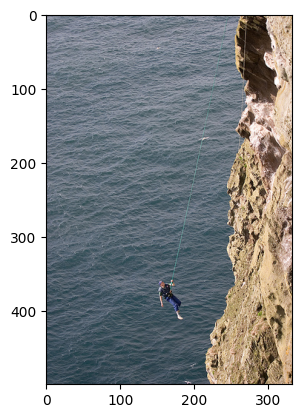

In [33]:
img = load_image(101)

In [34]:
text_list = ["Tırmanış yapan bir dağcı.","Denize iple sarkan bir yüzücü."]
# A climbing climber., A swimmer hanging to the sea with a rope. (The first  sentence makes sense in turkish :D)
predict(img,text_list)
original_clip_predict(img,text_list)

tensor([[0.9052, 0.0948]])
tensor([[0.9840, 0.0160]], grad_fn=<SoftmaxBackward0>)


In this example I tried to give a confusing caption. The second caption could confuse the model because there is a sea in the photo. The model could have easily thought the person is a swimmer. Also the hanging with a rope part is true which could have also confused the model. It seems that these were not enough to confuse the model.

100%|██████████| 50/50 [00:29<00:00,  1.72it/s]


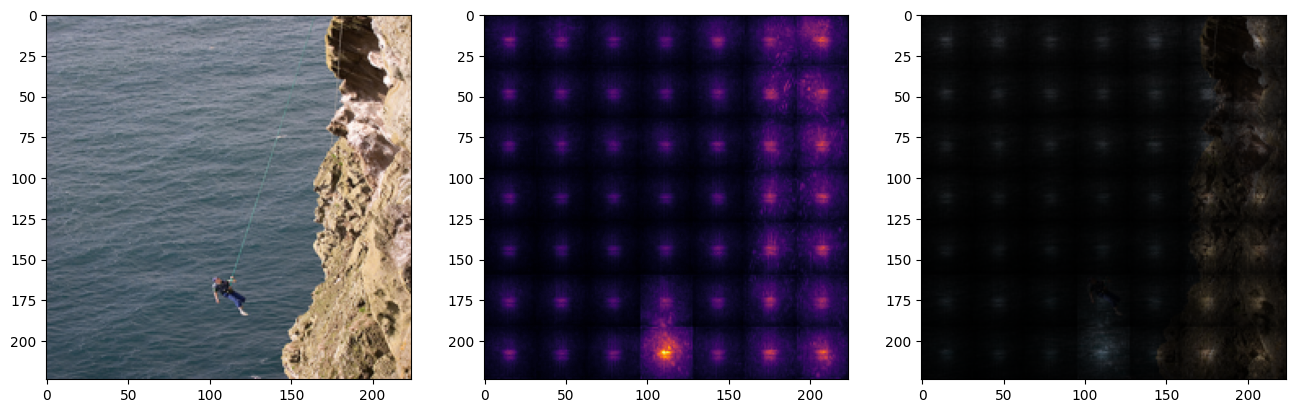

In [35]:
saliency = compute_saliency_map(101,text_list,class_num=0)

Caption 0:  Bir kadın ragbi takımı oyuncuları havadaki ragbi topunu yakalamaya çalışıyor.
Caption 1:  Havaya sıçrayarak topu kapmaya çalışan kadın ragbi oyuncuları.


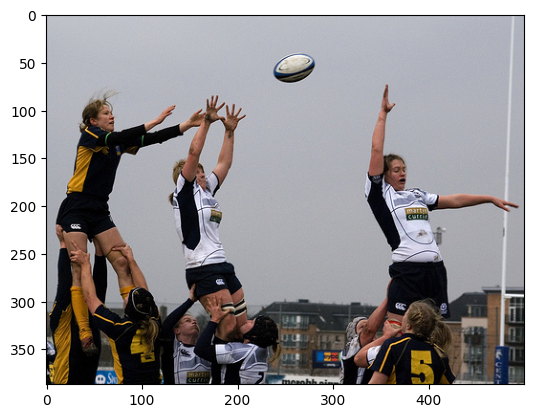

In [36]:
img = load_image(102)

In [37]:
text_list = ["Kadın voleybol takımı.","Kadın ragbi takımı."]
# Woman voleyball team. Woman rugby team.
predict(img,text_list)
original_clip_predict(img,text_list)

tensor([[0.8212, 0.1788]])
tensor([[0.9781, 0.0219]], grad_fn=<SoftmaxBackward0>)


Both models somehow think that this is a voleyball team.

100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


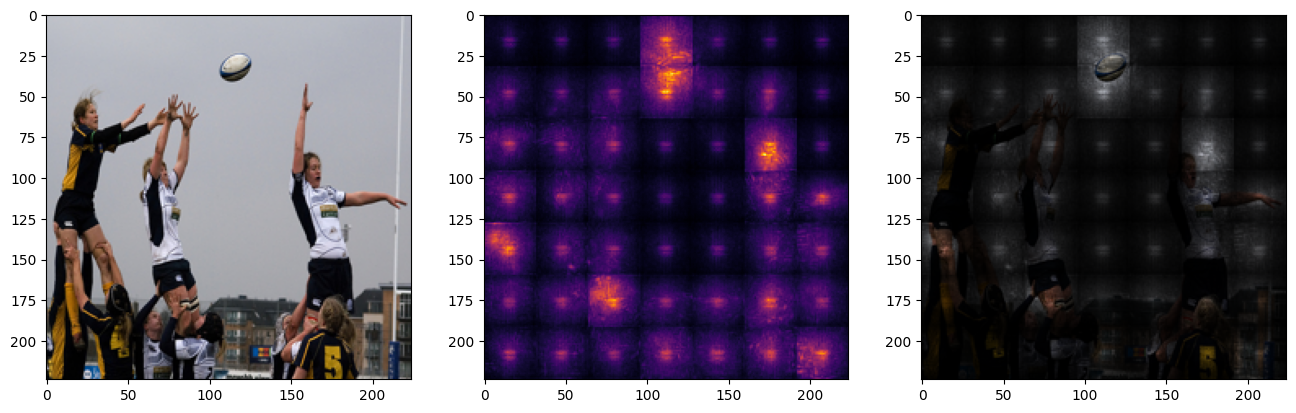

In [38]:
saliency = compute_saliency_map(102,text_list,class_num=1)

It seems that the original CLIP can actually perform good in Turkish from these images but if you check out the training notebook we compared the accuracy of the original CLIP and LORA CLIP for the validation set. You can see that as the number of captions increase the original CLIP's performance degragades. LORA CLIP has higher accuracy. Now lets look at the performance of our models in English and lets see if our LORA CLIP can still perform in English.

Caption 0:  Üç köpek kameraya doğru koşuyorlar.
Caption 1:  Bir köşesinde sulak bir kısmın bulunduğu bir çayırda koşan üç köpek.


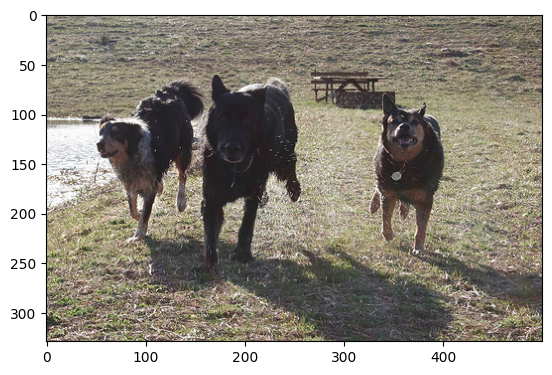

tensor([[0.0017, 0.1846, 0.8138]])
tensor([[0.0114, 0.3629, 0.6256]], grad_fn=<SoftmaxBackward0>)


In [39]:
img = load_image(100)
text_list = ["Two running dogs.","Three running dogs.","Four running dogs."]
predict(img,text_list)
original_clip_predict(img,text_list)

Both models somehow got the caption wrong, it might be due to prompting of the captions

Caption 0:  Gün batımında sahilde oyun oynayan iki erkek çocuğu.
Caption 1:  İki çocuk güneş ufuktayken bir sahilde birlikte oyun oynuyorlar.


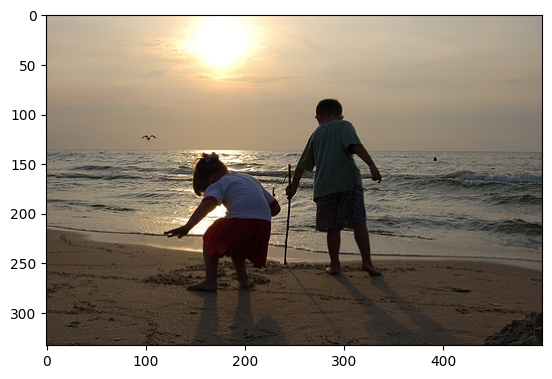

tensor([[0.8768, 0.0174, 0.1058]])
tensor([[0.9021, 0.0181, 0.0799]], grad_fn=<SoftmaxBackward0>)


In [40]:
img = load_image(400)
text_list = ["Two kids playing with sand during sun set", "Two kids playing with sand at night", "Three kids playing with sand"]
predict(img,text_list)
original_clip_predict(img,text_list)

Our LORA model still works in English!

Caption 0:  Şelaleden akan su içinde dolaşan kız.
Caption 1:  Bir kız şelanin önünde sularda yürüyor.


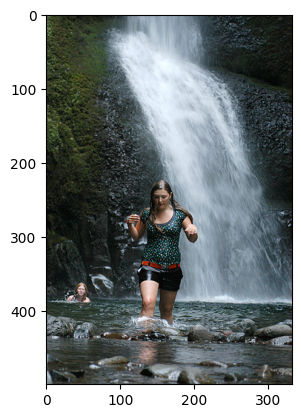

tensor([[0.5702, 0.4298]])
tensor([[0.8477, 0.1523]], grad_fn=<SoftmaxBackward0>)


In [41]:
img = load_image(950)
text_list = ["Water flows from the waterfall.","Flame flows from the waterfall."]
predict(img,text_list)
original_clip_predict(img,text_list)

Again our LORA model thinks flamable waterfalls are a thing (due to high probability) but it still gets the asnwer right

Caption 0:  Bir kadın ragbi takımı oyuncuları havadaki ragbi topunu yakalamaya çalışıyor.
Caption 1:  Havaya sıçrayarak topu kapmaya çalışan kadın ragbi oyuncuları.


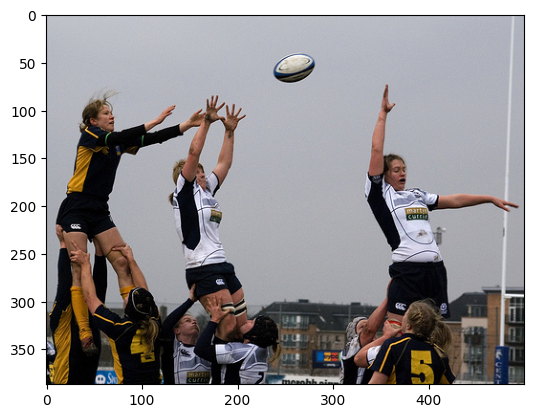

tensor([[0.0026, 0.9974]])
tensor([[2.0680e-04, 9.9979e-01]], grad_fn=<SoftmaxBackward0>)


In [42]:
img = load_image(102)
text_list = ["Woman voleyball team.", "Woman rugby team."]
predict(img,text_list)
original_clip_predict(img,text_list)

This example is really interesting because both models couldn't get this example rigth in Turkish but they both predict the caption right in English!

Caption 0:  Mavi tişörtlü bir çocuk kaykay yapıyor.
Caption 1:  Kaykaylı bir adam sokakta kayarken.


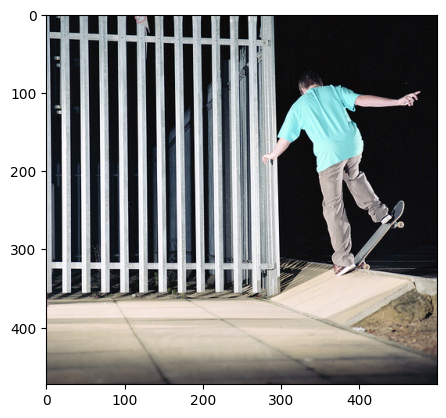

tensor([[0.8513, 0.1098, 0.0389]])
tensor([[0.6629, 0.2767, 0.0604]], grad_fn=<SoftmaxBackward0>)


In [43]:
img = load_image(600)
text_list = ["A skateboarder with a blue t-shirt", "A skateboarder with a yellow t-shirt", "A skateboarder with a red t-shirt"]
predict(img,text_list)
original_clip_predict(img,text_list)

Once again our model gets this right in English but not in Turkish.
Interestingly LORA model gives higher probabilty to correct caption then the original CLIP.
Since our model gets these correct in English but not in Turkish it  probably means that we need to improve our performance on Turkish. This  can be due to not finetuning (not enough hyperparameter search, etc.) or the amount of data. We can't really understand the performance using only a couple of images with 3-4 captions. Lets check the accuracy on validation set in English. Now lets load the original English  captions.

In [46]:
english_data = pd.read_csv("captions.txt",sep=",")

In [47]:
english_data

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40454  A rock climber practices on a rock climbing wa...  

[40455 rows x 2 columns]

Now we will change the format of the data

In [48]:
english_selected_data = []

for row in data[7000:]["images"]:
    file_name = row["filename"]

    caption_list = list(english_data[english_data["image"].values == file_name]["caption"].values)

    english_selected_data.append([file_name,caption_list])

Now we will use the dataset class we wrote in training notebook with some small changes for English captions

In [49]:
class Image_dataset(Dataset):
    def __init__(self, root_dir, data_frame, processor):

        self.root_dir = root_dir
        self.data_frame = data_frame
        self.processor = processor

        self.data_list = []

        for row in self.data_frame:
          file_name = row[0]
          sentence_list = row[1]

          self.data_list.append([file_name,sentence_list])

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name, captions = self.data_list[idx]
        try:
          img = Image.open(os.path.join(self.root_dir,image_name))
        except Exception as e:
          print(e)

        #load caption randomly

        caption = np.random.choice(captions)

        return img, caption

In [50]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

val_set = Image_dataset(
    root_dir = "Images",
    data_frame = english_selected_data,
    processor=processor
)


def customBatchBuilder(samples):
    img, caption = zip(*samples)

    inputs = processor(text=caption, images=img, return_tensors="pt", padding=True)

    return inputs

val_set_size = len(val_set)
print("Val set size:", val_set_size)

criterion = nn.CrossEntropyLoss()

batch_size = 64

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=customBatchBuilder)


Val set size: 1000


In [51]:
def test(model):
  with torch.no_grad():
    running_corrects = 0.0
    running_loss = 0.0
    for sample in tqdm(val_loader):
        input_ids, attention_mask,pixel_values = sample['input_ids'], sample['attention_mask'], sample ['pixel_values']
        batch_size = input_ids.size(0)
        input_ids = input_ids
        attention_mask = attention_mask
        pixel_values = pixel_values


        with torch.set_grad_enabled(False):
            outputs = model(
                input_ids, pixel_values , attention_mask
            )
            logits_per_image = outputs.logits_per_image
            logits_per_text = outputs.logits_per_text


            targets = torch.arange(logits_per_image.size(0)).long()

            _ , preds = torch.max(logits_per_image, 1)

            texts_loss = criterion(logits_per_text, targets)
            images_loss = criterion(logits_per_image, targets)
            loss = (images_loss + texts_loss) / 2.0
            running_loss += loss * batch_size
            running_corrects += torch.sum(preds == targets)


    val_acc = running_corrects.item() / len(val_set)
    val_loss = running_loss.item() / len(val_set)
  return val_acc,val_loss

In [52]:
acc,loss = test(model)
print("Accuracy: {}, Loss: {}".format(acc,loss))

100%|██████████| 16/16 [03:07<00:00, 11.73s/it]

Accuracy: 0.868, Loss: 0.359086181640625


Wow our model can still get nearly %87 of the captions right!!

In [53]:
acc,loss = test(original_clip_model)
print("Accuracy: {}, Loss: {}".format(acc,loss))

100%|██████████| 16/16 [03:13<00:00, 12.11s/it]

Accuracy: 0.874, Loss: 0.405825439453125


The accuracy of the original model is higher than the LORA CLIP but slightly. Also we should consider that due to randomness (shuffling and randomly selecting captions) the accuracies may vary for different runs. So this means that our model can still perform in English 😎!! 